# Dynamic Factor Analysis: Predictive Performance Comparison

This notebook compares different DFA algorithms (EM, Gibbs, VBEM) based on their log-predictive density and WAIC scores rather than runtime performance.

In [1]:
import os

# Set cuda device to use
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# do not prealocate memory
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"] = "platform"

import jax
device = 'cpu'
parallel_scan = device == 'gpu'
jax.config.update('jax_default_device', device)
# jax.config.update("jax_enable_x64", True)
jax.config.update('jax_default_matmul_precision', 'highest')

In [2]:
# Testing Dynamic Factor Analysis (DFA)
import jax.numpy as jnp
import jax.random as jr
import jax.tree_util as jtu
import matplotlib.pyplot as plt
import equinox as eqx
import numpy as np
from fastprogress.fastprogress import progress_bar
from jax import block_until_ready, vmap
from functools import partial
from typing import Tuple, Dict, List
from jax.scipy.special import logsumexp

from sppcax.models import BayesianDynamicFactorAnalysis as BDFA
from dynamax.linear_gaussian_ssm import parallel_lgssm_filter
from dynamax.linear_gaussian_ssm import lgssm_filter
from sppcax.inference.filtering import lgssm_filter as sppcax_filter
from sppcax.distributions import MultivariateNormalInverseGamma as MVNIG

kalman_filter = parallel_lgssm_filter if parallel_scan else lgssm_filter

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context="notebook", style="dark")

## 1. Data Generation Functions

We'll use the same data generation functions as the original benchmark, but generate multiple time series from the same parameters.

In [3]:
def generate_stable_matrix(key, dim, min_decay=0.95):
    key, _key = jr.split(key)
    Q, _ = jnp.linalg.qr(jr.normal(_key, shape=(dim, dim)))

    key, _key = jr.split(key)
    magnitudes = min_decay + jr.uniform(_key, shape=(dim,)) * (1 - min_decay)
    eigenvals = jnp.zeros(dim) + 1j * 0.0

    i = 0
    while i < dim:
        key, _key = jr.split(key)
        mag = magnitudes[i]
        if i < dim - 1 and jr.uniform(_key) > 0.5:
            angle = (jr.uniform(_key) - .5) * jnp.pi / 2
            eigenvals = eigenvals.at[i].set(mag * jnp.exp(1j * angle))
            eigenvals = eigenvals.at[i + 1].set(mag * jnp.exp(-1j * angle))
            i += 2
        else:
            eigenvals = eigenvals.at[i].set(mag * jnp.exp(1j * 0))
            i += 1

    D = jnp.diag(eigenvals)
    A = Q @ D @ Q.mT.conj()

    return A.real

def generate_params(key, dim_y, dim_z):
    # True parameters
    key, _key = jr.split(key)
    A_true = generate_stable_matrix(_key, dim_z)

    key, subkey = jr.split(key)
    Q_true_diag = jr.uniform(subkey, (dim_z,), minval=0.05, maxval=0.1)
    Q_true = jnp.diag(Q_true_diag)

    key, subkey1, subkey2 = jr.split(key, 3)
    H_true = jr.normal(subkey1, (dim_y, dim_z)) * jr.bernoulli(subkey2, p=0.3, shape=(dim_y, dim_z))
    sorted_idx = jnp.argsort(jnp.isclose(H_true, 0.0).sum(0))
    H_true = H_true[:, sorted_idx]

    key, subkey = jr.split(key)
    R_true_diag = jr.uniform(subkey, (dim_y,), minval=0.5, maxval=1.0)
    R_true = jnp.diag(R_true_diag)

    return (A_true, Q_true, H_true, R_true)

def generate_data_with_params(key, timesteps, dim_y, dim_z, params_true):
    """Generate data with fixed parameters."""
    A_true, Q_true, H_true, R_true = params_true
    
    z0_true = jnp.zeros(dim_z)
    Sigma0_true = jnp.eye(dim_z)

    # Generate latent states (z) and observations (y)
    z_true = jnp.zeros((timesteps, dim_z))
    y_obs = jnp.zeros((timesteps, dim_y))

    key, subkey1, subkey2 = jr.split(key, 3)
    z_curr = jr.multivariate_normal(subkey1, z0_true, Sigma0_true)
    z_true = z_true.at[0].set(z_curr)
    y_obs = y_obs.at[0].set(jr.multivariate_normal(subkey2, H_true @ z_curr, R_true))

    for t in range(1, timesteps):
        key, subkey1, subkey2 = jr.split(key, 3)
        z_curr = jr.multivariate_normal(subkey1, A_true @ z_curr, Q_true)
        z_true = z_true.at[t].set(z_curr)
        y_obs = y_obs.at[t].set(jr.multivariate_normal(subkey2, H_true @ z_curr, R_true))

    return y_obs, z_true, params_true

def generate_multiple_datasets(key, num_datasets, timesteps, dim_y, dim_z):
    """Generate multiple time series from the same set of parameters."""
    # First generate the true parameters
    key, param_key = jr.split(key)
    params_true = generate_params(param_key, dim_y, dim_z)
    
    # Generate multiple datasets with these fixed parameters
    datasets = []
    keys = jr.split(key, num_datasets)

    func = lambda key: generate_data_with_params(key, timesteps, dim_y, dim_z, params_true)
    y_obs, z_true, _ = jax.vmap(func)(keys)
    
    return y_obs, z_true, params_true

## 2. WAIC and Log-Predictive Density Functions

We'll implement WAIC (Widely Applicable Information Criterion) and log-predictive density calculations.

In [4]:
def compute_waic(pointwise_lls):
    """Compute WAIC (Widely Applicable Information Criterion).
    
    WAIC = -2 * (lppd - p_waic)
    where:
    - lppd = log pointwise predictive density
    - p_waic = effective number of parameters (penalty)
    
    Args:
        pointwise_lls: log-likelihood for every sampled time series
            
    Returns:
        waic: WAIC score
        lppd: Log pointwise predictive density
        p_waic: Effective number of parameters
    """    
    # Compute log pointwise predictive density
    # lppd = sum_i log(mean_s(exp(ll_si)))
    lppd = jnp.sum(logsumexp(pointwise_lls - jnp.log(len(pointwise_lls)), axis=0))
    
    # Compute effective number of parameters
    # p_waic = sum_i var_s(ll_si)
    p_waic = jnp.sum(jnp.var(pointwise_lls, axis=0))
    
    # WAIC
    waic = -2 * (lppd - p_waic)
    
    return {'waic': waic, 'lppd': lppd, 'p_waic': p_waic}

def compute_log_likelihood(posterior_sample, y_obs, inputs=None):
    if inputs is None:
        kf = lambda params: jax.vmap(kalman_filter, in_axes=(None, 0))(params, y_obs) 
    else:
        kf = lambda params: jax.vmap(kalman_filter, in_axes=(None, 0, 0))(params, y_obs, inputs)
    
    out = jax.vmap(kf)(posterior_sample)

    return out.marginal_loglik

## 3. Algorithm Fitting Functions

Functions to fit each algorithm and extract posterior samples or point estimates.

In [ ]:
def create_posterior_samples(key, init_params, props, y_train, u_train, model, num_samples=100):
    """Create posterior samples around a point estimate for EM/VBEM.
    
    We use Blocked-Gibbs sample to generate samples from the posterior by generating 
    a single sample using posterior param estimate as initial parameters of the 
    sampler. 
    """

    func = partial(model.fit_blocked_gibbs, initial_params=init_params, props=props, sample_size=2, emissions=y_train, inputs=u_train, verbose=False)
    
    # Add noise to each parameter
    keys = jr.split(key, num_samples)
    samples, _ = eqx.filter_jit(eqx.filter_vmap(func))(keys)
    
    return jtu.tree_map(lambda x: x[:, -1], samples)

def fit_em_algorithm(key, y_train, y_test, u_train, u_test, dim_z, dim_y, num_iters=100, num_samples=100, **kwargs):
    """Fit EM algorithm, estimate waic, and return metrics plus elbo sequence."""

    input_dim = u_train.shape[-1]
    emission_prior = MVNIG(
        jnp.zeros((dim_y, dim_z + input_dim + 1)),
        precision=jnp.eye(dim_z + input_dim + 1),
        alpha0=2.0,
        beta0=1.0,
        isotropic_noise=False,
    )

    dynamics_prior = MVNIG(
        jnp.zeros((dim_z, dim_z + input_dim + 1)),
        precision=jnp.eye(dim_z + input_dim + 1),
        alpha0=2.0,
        beta0=1.0,
        isotropic_noise=False,
    )

    dfa_model = BDFA(
        dim_z,
        dim_y,
        input_dim=input_dim,
        parallel_scan=parallel_scan,
        emission_prior=emission_prior,
        dynamics_prior=dynamics_prior
    )
    
    use_bmr_em = kwargs.pop('use_bmr_em', False)
    use_bmr_dyn = kwargs.pop('use_bmr_dyn', False)
    dfa_model.use_bmr = eqx.tree_at(lambda x: (x.emissions, x.dynamics), dfa_model.use_bmr, (use_bmr_em, use_bmr_dyn))
    
    key, _key = jr.split(key)
    init_params, props = dfa_model.initialize(
        _key
    )
    
    key, _key = jr.split(key)
    updated_params, elbos = eqx.filter_jit(dfa_model.fit_em)(
        init_params, props, y_train, _key, U=u_train, num_iters=num_iters, verbose=False
    )

    key, _key = jr.split(key)
    pseudo_sample = create_posterior_samples(_key, updated_params, props, y_train, u_train, dfa_model, num_samples=num_samples)

    marginal_ll = compute_log_likelihood(pseudo_sample, y_test, inputs=u_test)

    metrics = compute_waic(marginal_ll)
    
    return metrics, elbos

def fit_vbem_algorithm(key, y_train, y_test, u_train, u_test, dim_z, dim_y, num_iters=100, num_samples=100, **kwargs):
    """Fit VBEM algorithm, estimate waic, and return metrics plus elbo sequence."""
    input_dim = u_train.shape[-1]
    emission_prior = MVNIG(
        jnp.zeros((dim_y, dim_z + input_dim + 1)),
        precision=jnp.eye(dim_z + input_dim + 1),
        alpha0=2.0,
        beta0=1.0,
        isotropic_noise=False,
    )

    dynamics_prior = MVNIG(
        jnp.zeros((dim_z, dim_z + input_dim + 1)),
        precision=jnp.eye(dim_z + input_dim + 1),
        alpha0=2.0,
        beta0=1.0,
        isotropic_noise=False,
    )

    dfa_model = BDFA(
        dim_z,
        dim_y,
        input_dim=input_dim,
        parallel_scan=parallel_scan,
        emission_prior=emission_prior,
        dynamics_prior=dynamics_prior
    )

    use_bmr_em = kwargs.pop('use_bmr_em', False)
    use_bmr_dyn = kwargs.pop('use_bmr_dyn', False)
    dfa_model.use_bmr = eqx.tree_at(lambda x: (x.emissions, x.dynamics), dfa_model.use_bmr, (use_bmr_em, use_bmr_dyn))
    
    key, _key = jr.split(key)
    init_params, props = dfa_model.initialize(
        _key,
        variational_bayes=True
    )
    
    key, _key = jr.split(key)
    updated_params, elbos = eqx.filter_jit(dfa_model.fit_vbem)(
        init_params, props, y_train, _key, U=u_train, num_iters=num_iters, verbose=False
    )

    key, _key = jr.split(key)

    updated_params, _ = dfa_model.initialize(
        key,
        initial_mean = updated_params.initial.mean,
        initial_covariance = updated_params.initial.cov,
        dynamics_weights = updated_params.dynamics.weights,
        dynamics_bias = updated_params.dynamics.bias, 
        dynamics_input_weights = updated_params.dynamics.input_weights, 
        dynamics_covariance = updated_params.dynamics.cov,
        emission_weights = updated_params.emissions.weights,
        emission_bias = updated_params.emissions.bias,
        emission_input_weights = updated_params.emissions.input_weights,
        emission_covariance = updated_params.emissions.cov,
    )

    pseudo_sample = create_posterior_samples(_key, updated_params, props, y_train, u_train, dfa_model, num_samples=num_samples)

    marginal_ll = compute_log_likelihood(pseudo_sample, y_test, inputs=u_test)

    metrics = compute_waic(marginal_ll)
    
    return metrics, elbos


def fit_gibbs_algorithm(key, y_train, y_test, u_train, u_test, dim_z, dim_y, num_iters=300, burn_in=200, num_samples=100, **kwargs):
    """Fit Gibbs sampler and return posterior samples."""
    input_dim = u_train.shape[-1]
    emission_prior = MVNIG(
        jnp.zeros((dim_y, dim_z + input_dim + 1)),
        precision=jnp.eye(dim_z + input_dim + 1),
        alpha0=2.0,
        beta0=1.0,
        isotropic_noise=False,
    )

    dynamics_prior = MVNIG(
        jnp.zeros((dim_z, dim_z + input_dim + 1)),
        precision=jnp.eye(dim_z + input_dim + 1),
        alpha0=2.0,
        beta0=1.0,
        isotropic_noise=False,
    )

    dfa_model = BDFA(
        dim_z,
        dim_y,
        input_dim=input_dim,
        parallel_scan=parallel_scan,
        emission_prior=emission_prior,
        dynamics_prior=dynamics_prior
    )

    init_params, props = dfa_model.initialize(
        key
    )

    key, _key = jr.split(key)
    updated_params, elbos = eqx.filter_jit(dfa_model.fit_em)(
        init_params, props, y_train, _key, U=u_train, num_iters=max(num_iters - burn_in, 50), verbose=False
    )

    use_bmr_em = kwargs.pop('use_bmr_em', False)
    use_bmr_dyn = kwargs.pop('use_bmr_dyn', False)
    dfa_model.use_bmr = eqx.tree_at(lambda x: (x.emissions, x.dynamics), dfa_model.use_bmr, (use_bmr_em, use_bmr_dyn))
    
    posterior_samples, elbos = eqx.filter_jit(dfa_model.fit_blocked_gibbs)(
        key, updated_params, props, sample_size=burn_in + num_samples, burn_in=burn_in,
        emissions=y_train, inputs=u_train, verbose=False
    )
    
    marginal_ll = compute_log_likelihood(posterior_samples, y_test, inputs=u_test)
    metrics = compute_waic(marginal_ll)
    
    return metrics, elbos

## 4. Experimental Setup

Generate test data and run comparisons across different algorithms.

In [6]:
# Experimental parameters
key = jr.PRNGKey(42)
num_datasets = 30
num_train_datasets = 10
timesteps = 100

# Test different model dimensions
test_configs = [
    (20, 5),   # (dim_y, dim_z)
    (40, 10),
    (80, 20),
    (80, 40)
]

num_iters = 500

print(f"Running experiments with {num_train_datasets} for training and {num_datasets - num_train_datasets} for testing")
print(f"Testing configurations: {test_configs}")

Running experiments with 10 for training and 20 for testing
Testing configurations: [(20, 5), (40, 10), (80, 20), (80, 40)]


## 5. Run Experiments

Now let's run the experiments and collect results.

In [7]:
# Run experiments for each configuration
all_results = {}
num_test_datasets = 10
max_train_datasets = 10

input_dim = 10
key, data_key = jr.split(key)
input_datasets = jr.normal(data_key, shape=(num_test_datasets + max_train_datasets, timesteps, input_dim))

for dim_y, dim_z in test_configs:

    # Generate datasets
    key, data_key = jr.split(key)
    *datasets, params_true = generate_multiple_datasets(
        data_key, num_test_datasets + max_train_datasets, timesteps, dim_y, dim_z
    )

    config_results = {1: {}, 2: {}, 3: {}, 4: {}}
    for num_train_datasets in [2, 4, 8]:
        print(f"\nRunning experiments for dim_y={dim_y}, dim_z={dim_z}")
        print(f"\nUsing {num_train_datasets} timeseries batches for training")
        
        y_train = datasets[0][:num_train_datasets]
        y_test = datasets[0][-num_test_datasets:]

        u_train = input_datasets[:num_train_datasets]
        u_test = input_datasets[-num_test_datasets:]

        print("\nWithout BMR")
        res = []
        for algo, fit in zip(['MAP-EM', 'VBEM', 'Gibbs'], [fit_em_algorithm, fit_vbem_algorithm, fit_gibbs_algorithm]):
            key, _key = jr.split(key)
            metrics, elbos = fit(_key, y_train, y_test, u_train, u_test, dim_z, dim_y, num_iters=num_iters)
            print(f"ELBO {algo}", elbos[-1] / num_train_datasets)
            res.append((algo, metrics))
        
        config_results[1][num_train_datasets] = res

        print("\nWith BMR on emissions")
        res = []
        for algo, fit in zip(['MAP-EM', 'VBEM', 'Gibbs'], [fit_em_algorithm, fit_vbem_algorithm, fit_gibbs_algorithm]):
            key, _key = jr.split(key)
            metrics, elbos = fit(_key, y_train, y_test, u_train, u_test, dim_z, dim_y, num_iters=num_iters, use_bmr_em=True)
            print(f"ELBO {algo}", elbos[-1] / num_train_datasets)
            res.append((algo, metrics))
        
        config_results[2][num_train_datasets] = res

        print("\nWith BMR on dynamics")
        res = []
        for algo, fit in zip(['MAP-EM', 'VBEM', 'Gibbs'], [fit_em_algorithm, fit_vbem_algorithm, fit_gibbs_algorithm]):
            key, _key = jr.split(key)
            metrics, elbos = fit(_key, y_train, y_test, u_train, u_test, dim_z, dim_y, num_iters=num_iters, use_bmr_dyn=True)
            print(f"ELBO {algo}", elbos[-1] / num_train_datasets)
            res.append((algo, metrics))
        
        config_results[3][num_train_datasets] = res

        print("\nWith BMR on both")
        res = []
        for algo, fit in zip(['MAP-EM', 'VBEM', 'Gibbs'], [fit_em_algorithm, fit_vbem_algorithm, fit_gibbs_algorithm]):
            key, _key = jr.split(key)
            metrics, elbos = fit(_key, y_train, y_test, u_train, u_test, dim_z, dim_y, num_iters=num_iters, use_bmr_em=True, use_bmr_dyn=True)
            print(f"ELBO {algo}", elbos[-1] / num_train_datasets)
            res.append((algo, metrics))
        
        config_results[4][num_train_datasets] = res
        
    all_results[(dim_y, dim_z)] = config_results

print("\nAll experiments completed!")


Running experiments for dim_y=20, dim_z=5

Using 2 timeseries batches for training

Without BMR
ELBO MAP-EM -3057.3647
ELBO VBEM -3414.7722
ELBO Gibbs -3140.8208

With BMR on emissions
ELBO MAP-EM -2742.6924
ELBO VBEM -2930.7588
ELBO Gibbs -2787.3186

With BMR on dynamics
ELBO MAP-EM -2997.9058
ELBO VBEM -3294.9543
ELBO Gibbs -3068.961

With BMR on both
ELBO MAP-EM -2702.0454
ELBO VBEM -2869.5957
ELBO Gibbs -2814.9329

Running experiments for dim_y=20, dim_z=5

Using 4 timeseries batches for training

Without BMR
ELBO MAP-EM -2913.8887
ELBO VBEM -3161.0364
ELBO Gibbs -2961.2307

With BMR on emissions
ELBO MAP-EM -2744.6218
ELBO VBEM -2909.7522
ELBO Gibbs -2766.745

With BMR on dynamics
ELBO MAP-EM -2863.709
ELBO VBEM -3106.3777
ELBO Gibbs -2920.6663

With BMR on both
ELBO MAP-EM -2728.3682
ELBO VBEM -2860.4492
ELBO Gibbs -2715.372

Running experiments for dim_y=20, dim_z=5

Using 8 timeseries batches for training

Without BMR
ELBO MAP-EM -2812.3372
ELBO VBEM -3023.1487
ELBO Gibbs -283

## 6. Results Analysis and Visualization

Let's analyze and visualize the results.

In [8]:
# Aggregate results
import pandas as pd
import numpy as np

def aggregate_results(all_results, i=1):
    """Aggregate results into a DataFrame for analysis."""
    rows = []
    
    for (dim_y, dim_z), results in all_results.items():
        for num_datasets, sequence in results[i].items():
            for algorithm, metrics in sequence:
                row = {
                    'dim_y': dim_y,
                    'dim_z': dim_z,
                    'num_datasets': num_datasets,
                    'algorithm': algorithm,
                    **jtu.tree_map(lambda x: x.item() / num_test_datasets, metrics)
                }
                rows.append(row)
    
    return pd.DataFrame(rows)

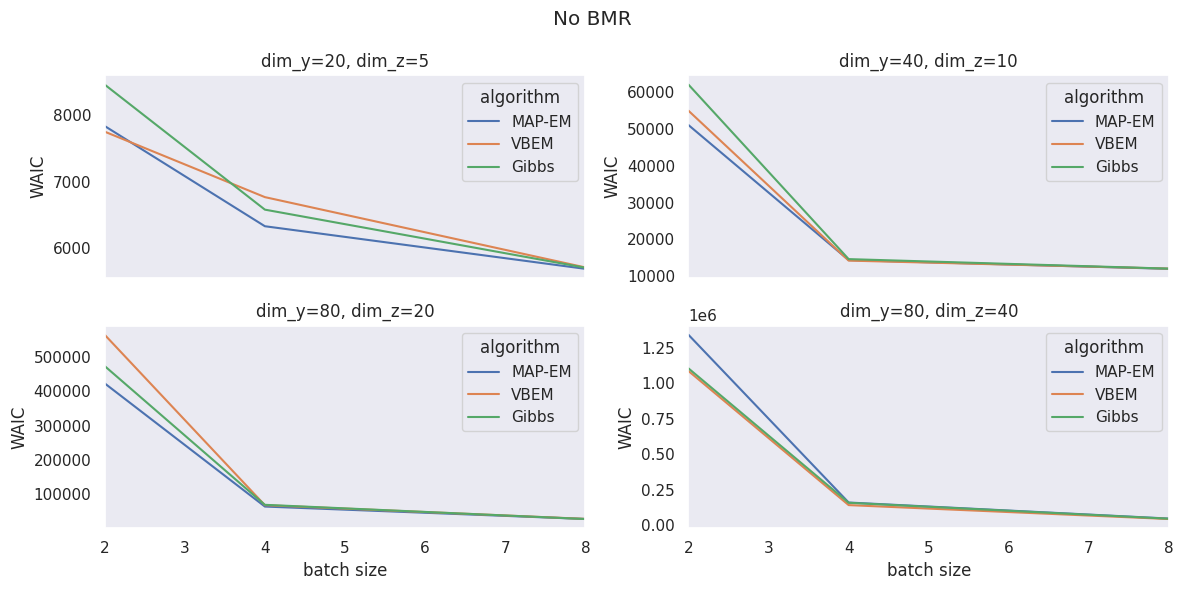

In [9]:
results_df = aggregate_results(all_results, i=1)

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(12, 6), sharex=True)

# WAIC comparison

i = 0
for dim_y, dim_z in test_configs:
    ax = axes.flatten()[i]
    data = results_df.loc[(results_df.dim_y == dim_y) * (results_df.dim_z == dim_z)]
    sns.lineplot(data=data, x='num_datasets', y='waic', hue='algorithm', ax=ax)
    ax.set_xlim([2, 8])
    # ax.set_ylim([0, 1e4 + 2 * i ** 4 * 1e4])
    ax.set_title(f'dim_y={dim_y}, dim_z={dim_z}')
    ax.set_ylabel('WAIC')
    ax.set_xlabel('batch size')
    i += 1

fig.suptitle('No BMR')
fig.tight_layout()

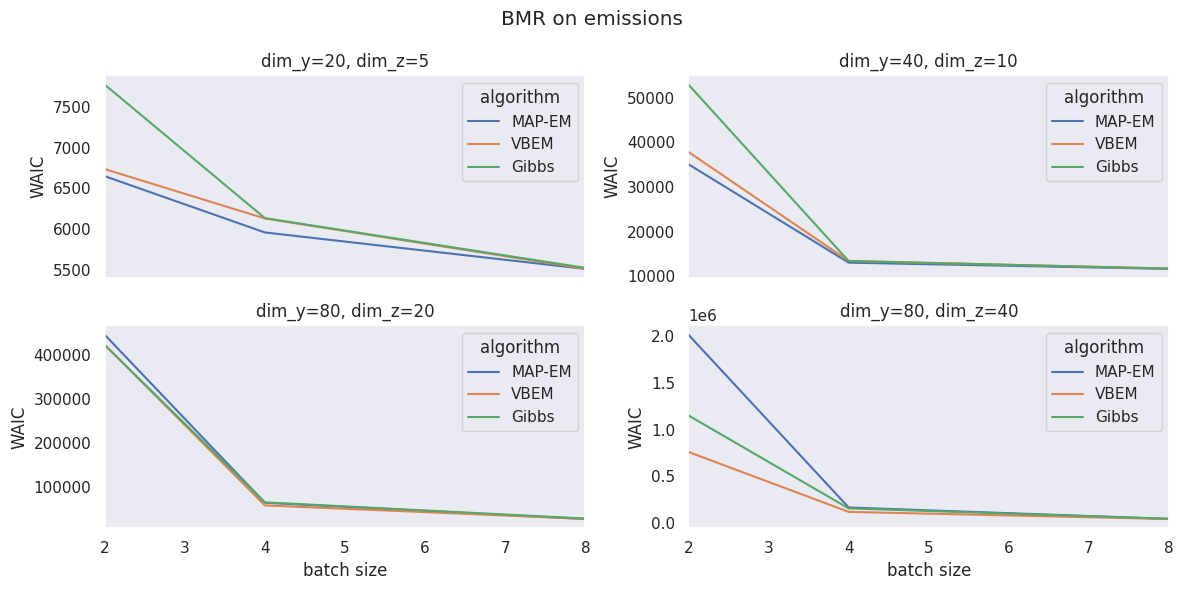

In [11]:
results_df = aggregate_results(all_results, i=2)

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(12, 6), sharex=True)

# WAIC comparison

i = 0
for dim_y, dim_z in test_configs:
    ax = axes.flatten()[i]
    data = results_df.loc[(results_df.dim_y == dim_y) * (results_df.dim_z == dim_z)]
    sns.lineplot(data=data, x='num_datasets', y='waic', hue='algorithm', ax=ax)
    ax.set_xlim([2, 8])
    # ax.set_ylim([0, 2.5 * 1e4 + 2 * i ** 2 * 1e4])
    ax.set_title(f'dim_y={dim_y}, dim_z={dim_z}')
    ax.set_ylabel('WAIC')
    ax.set_xlabel('batch size')
    i += 1

fig.suptitle('BMR on emissions')
fig.tight_layout()

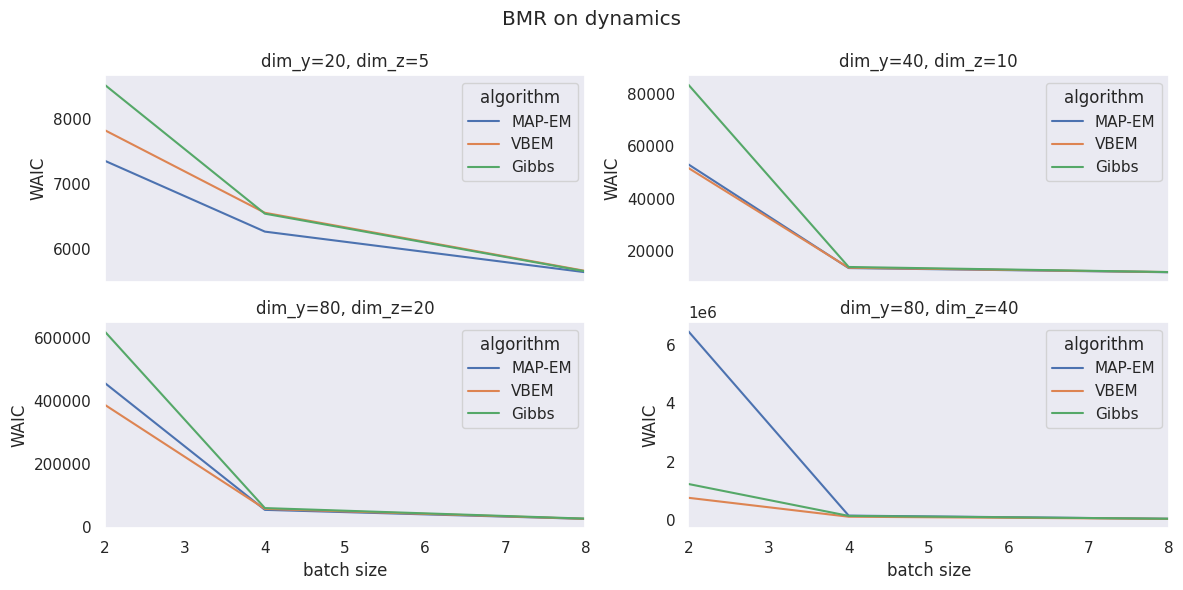

In [12]:
results_df = aggregate_results(all_results, i=3)

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(12, 6), sharex=True)

# WAIC comparison

i = 0
for dim_y, dim_z in test_configs:
    ax = axes.flatten()[i]
    data = results_df.loc[(results_df.dim_y == dim_y) * (results_df.dim_z == dim_z)]
    sns.lineplot(data=data, x='num_datasets', y='waic', hue='algorithm', ax=ax)
    ax.set_xlim([2, 8])
    # ax.set_ylim([0, 2.5 * 1e4 + 2 * i ** 2 * 1e4])
    ax.set_title(f'dim_y={dim_y}, dim_z={dim_z}')
    ax.set_ylabel('WAIC')
    ax.set_xlabel('batch size')
    i += 1

fig.suptitle('BMR on dynamics')
fig.tight_layout()

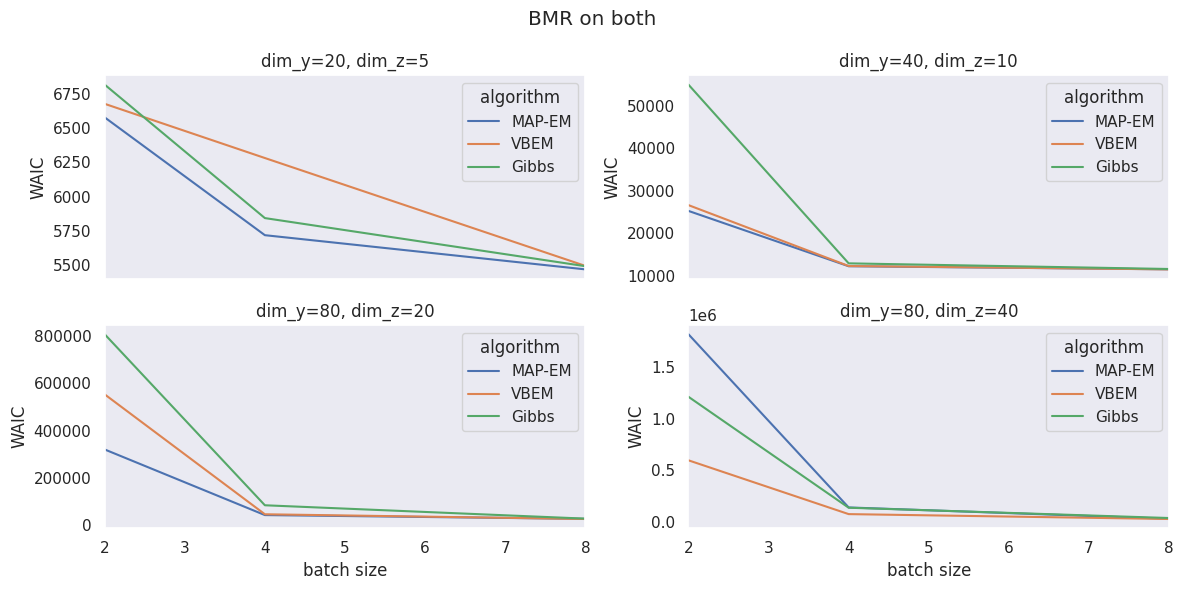

In [13]:
results_df = aggregate_results(all_results, i=4)

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(12, 6), sharex=True)

# WAIC comparison

i = 0
for dim_y, dim_z in test_configs:
    ax = axes.flatten()[i]
    data = results_df.loc[(results_df.dim_y == dim_y) * (results_df.dim_z == dim_z)]
    sns.lineplot(data=data, x='num_datasets', y='waic', hue='algorithm', ax=ax)
    ax.set_xlim([2, 8])
    # ax.set_ylim([0, 2.5 * 1e4 + 2 * i ** 2 * 1e4])
    ax.set_title(f'dim_y={dim_y}, dim_z={dim_z}')
    ax.set_ylabel('WAIC')
    ax.set_xlabel('batch size')
    i += 1

fig.suptitle('BMR on both')
fig.tight_layout()

## 7. Conclusions

This notebook compared three DFA algorithms (EM, blocked-Gibbs sampling, and VBEM) based on their predictive performance. Key findings:

### Metrics Used:
- **WAIC (Widely Applicable Information Criterion)**: A measure of out-of-sample predictive accuracy that balances fit and complexity

### Key Insights:
1. **blocked-Gibbs sampling** where parameters are sampled from a posterior distribution estimated during the m-step, and latent states are sampled in the backward pass during the e-step.
2. **EM** runs the e-step around the mode of the posterior. 
3. **VBEM** provides a full variational Bayesian EM algorithm, where the e-step is estimated around posterior expectation of the log-joint distribution.

### Recommendations:
- Use **EM** when computational resources are limited.
- Use **VBEM** in low data regimes, relative to problem size.

The choice between algorithms should depend on your specific requirements for accuracy, uncertainty quantification, and computational constraints.

NOTE: All three algorithms are using codnitionally conjugate updates for the posterior over model parameters. They only differ in the way e-step, and sufficient statistics is estimated.